# Does Money Really Buy Happiness?

We've all heard money doesn't buy happiness. But at the country level… does it?

In this notebook, I explore the relationship between national income and life satisfaction across countries. Using GDP per capita and happiness data, I examine the strength of their relationship through correlation, regression analysis, and residual exploration.

I will look at how much of happiness income can explain and where it falls short. Along the way, I’ll take a small world tour: from Latin America  to Northern Europe, uncovering countries that are happier (or less happy) than their income alone would predict.

Let’s see what the data says.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

sns.set(style="whitegrid")


# Data Preparation

## Data Sources

This analysis combines data from two primary sources:

* United Nations – World Happiness Report

  Source: https://www.worldhappiness.report/data-sharing/

  This dataset provides country-level life evaluation scores (happiness) along with related well-being indicators.

* World Bank – GDP per Capita (PPP, current international $)

  Source: https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2024&start=2020&view=chart

  GDP per capita (PPP) is used as a standardized measure of national income, allowing for meaningful comparisons across countries.


In [ ]:
# Happiness data
happiness_df = pd.read_excel("world_happiness.xlsx")

happiness_df.head()
happiness_df.info()

# GDP data
# Skip the first 4 rows which contain metadata
gdp_raw_df = pd.read_csv("GDP_per_capita.csv", skiprows=4)

gdp_raw_df.head()
gdp_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Year                                        1969 non-null   int64  
 1   Rank                                        1969 non-null   int64  
 2   Country name                                1969 non-null   object 
 3   Life evaluation (3-year average)            1969 non-null   float64
 4   Lower whisker                               875 non-null    float64
 5   Upper whisker                               875 non-null    float64
 6   Explained by: Log GDP per capita            872 non-null    float64
 7   Explained by: Social support                872 non-null    float64
 8   Explained by: Healthy life expectancy       870 non-null    float64
 9   Explained by: Freedom to make life choices  871 non-null    float64
 10  Explained by

## Basic Data Cleaning and Merging

To prepare the dataset for analysis, I first cleaned and standardized both sources. In the World Happiness Report data (happiness_df), I renamed the column “Life evaluation (3-year average)” to “Happiness” for clarity and selected only Country name, Year, and Happiness, filtering the data to include only observations from 2024.

For the World Bank GDP data (gdp_raw_df), which was originally in wide format with separate columns for each year, I reshaped it into a long format using the melt function. This created a structured dataset with Country Name, Year, and GDP per capita columns. I then filtered the GDP data to retain only values for 2024.

Finally, I merged the cleaned happiness and GDP datasets based on country and year, creating a unified dataset ready for correlation and regression analysis.

In [ ]:
# Rename Life evaluation (3-year average) to happiness

happiness_df.rename(columns={'Life evaluation (3-year average)': 'Happiness'}, inplace=True)
happiness_df.head()

,Year,Rank,Country name,Happiness,Lower whisker,Upper whisker,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,2024,147,Afghanistan,1.364,1.301,1.427,0.649,0.0,0.155,0.0,0.075,0.135,0.348
1,2023,143,Afghanistan,1.721,1.667,1.775,0.628,0.0,0.242,0.0,0.091,0.088,0.672
2,2022,137,Afghanistan,1.859,1.795,1.923,0.645,0.0,0.087,0.0,0.093,0.059,0.976
3,2021,146,Afghanistan,2.404,2.339,2.469,0.758,0.0,0.289,0.0,0.089,0.005,1.263
4,2020,150,Afghanistan,2.523,2.449,2.596,0.370,0.0,0.126,0.0,0.122,0.010,1.895


In [ ]:
# Select 'Country name', 'Year', and the newly renamed 'Happiness' column from `happiness_df`
# Then filter the data to include only the year 2024

happiness_2024 = happiness_df[happiness_df['Year'] == 2024][['Country name', 'Year', 'Happiness']]
happiness_2024.head()

,Country name,Year,Happiness
0,Afghanistan,2024,1.364
13,Albania,2024,5.411
26,Algeria,2024,5.571
45,Argentina,2024,6.397
58,Armenia,2024,5.494


In [ ]:
# Transform `gdp_raw_df` from wide to long format
# Select 'Country Name', 'Year', and the corresponding GDP per capita value
# Filter for year 2024

year_columns = [col for col in gdp_raw_df.columns if col.isdigit()]
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']

gdp_melt_columns = id_vars + year_columns

gdp_long_df = pd.melt(gdp_raw_df[gdp_melt_columns],
                      id_vars=id_vars,
                      var_name='Year',
                      value_name='GDP per capita')

gdp_long_df['Year'] = gdp_long_df['Year'].astype(int)

gdp_2024_df = gdp_long_df[gdp_long_df['Year'] == 2024]
gdp_2024_df = gdp_2024_df[['Country Name', 'Year', 'GDP per capita']]

gdp_2024_df.head()

,Country Name,Year,GDP per capita
17024,Aruba,2024,50649.301523
17025,Africa Eastern and Southern,2024,4635.788224
17026,Afghanistan,2024,NaN
17027,Africa Western and Central,2024,6815.990961
17028,Angola,2024,10118.608995


In [ ]:
# Merge 'happiness_2024' and 'gdp_2024_df'into a single dataframe based on 'Country Name' and 'Year'

merged_df = pd.merge(happiness_2024, gdp_2024_df, left_on='Country name', right_on='Country Name', how='inner')
merged_df = merged_df[['Country name', 'Year_x', 'Happiness', 'GDP per capita']]
merged_df = merged_df.rename(columns={'Year_x': 'Year'})
merged_df.head()

,Country name,Year,Happiness,GDP per capita
0,Afghanistan,2024,1.364,NaN
1,Albania,2024,5.411,27146.381475
2,Algeria,2024,5.571,17620.742396
3,Argentina,2024,6.397,30431.193122
4,Armenia,2024,5.494,22823.179526


## Missing Values

There were only a small number of missing values in the dataset. Since the proportion was minimal and the analysis requires complete observations for regression, I removed rows with missing GDP or happiness values to ensure consistency in the results.

In [ ]:
# Check missing values

merged_df.isna().sum()

,0
Country name,0
Year,0
Happiness,0
GDP per capita,2


In [ ]:
# Drop countries with missing GDP or happiness values
# Since regression requires complete observations

merged_df = merged_df.dropna(subset=["GDP per capita", "Happiness"])
merged_df.shape

(128, 4)

## Log GDP

The relationship between income and happiness is not linear. An extra $1,000 matters much more in a low-income country than in a wealthy one. To capture this diminishing return effect, I used the logarithm of GDP per capita.

In [ ]:
# Apply a Logarithm to GDP

merged_df["log_gdp"] = np.log(merged_df["GDP per capita"])
merged_df.head()

,Country name,Year,Happiness,GDP per capita,log_gdp
1,Albania,2024,5.411,27146.381475,10.208999
2,Algeria,2024,5.571,17620.742396,9.776832
3,Argentina,2024,6.397,30431.193122,10.323223
4,Armenia,2024,5.494,22823.179526,10.035532
5,Australia,2024,6.974,72111.184463,11.185964


# Happiness vs Log_GDP

Text(0.5, 1.0, 'Happiness vs Log GDP per Capita')

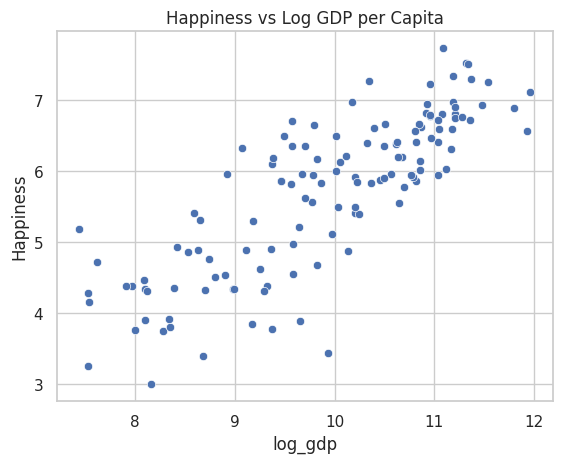

In [ ]:
# Happiness vs log_gdp

sns.scatterplot(data=merged_df, x="log_gdp", y="Happiness")
plt.title("Happiness vs Log GDP per Capita")

### Main Observation

There is a clear positive relationship.

As log GDP increases → happiness tends to increase.

That means richer countries are generally happier.

So at first glance…

Yes, money seems to buy happiness.

But Notice Something Important

The relationship is:

* Not perfectly linear
* Not tight
* There is visible spread

At similar income levels (around log_gdp ≈ 10),
happiness ranges from about 3.5 to 6.5.

That’s a big difference.

So GDP alone does not fully explain happiness.

### Diminishing Returns

Look at the right side:

From log_gdp ≈ 11 to 12 happiness increases only slightly.

But from log_gdp ≈ 8 to 9 happiness increases more noticeably.

This visually supports that the marginal benefit of income decreases at higher levels.

# Correlation

Correlation measures the strength and direction of a linear relationship between two variables.

It ranges from -1 to +1:
* +1 indicates a perfect positive relationship
* 0 indicates no linear relationship
* -1 indicates a perfect negative relationship

General rule of thumb:

|r value | Interpretation |
|---| ---|
|0.0-0.2|Very weak|
|0.2-0.4|Weak|
|0.4-0.6|Moderate|
|0.6-0.8|Strong|
|0.8-1.0|Very strong|

In [ ]:
# Correlation

corr = merged_df["log_gdp"].corr(merged_df["Happiness"])
print("Correlation:", round(corr, 3))


Correlation: 0.811


### What 0.811 Means?

The correlation between log GDP per capita and happiness is 0.811 indicating a very strong positive relationship.

In other words, richer countries tend to report substantially higher life satisfaction. Income alone appears to explain a large share of cross-country differences in happiness.

But 0.811 is not 1.

Roughly one-third of the variation in happiness remains unexplained by income. Something else is clearly at work.

# Regression

In [ ]:
# Regression

X = sm.add_constant(merged_df["log_gdp"])
y = merged_df["Happiness"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     243.0
Date:                Wed, 18 Feb 2026   Prob (F-statistic):           3.50e-31
Time:                        04:38:22   Log-Likelihood:                -124.18
No. Observations:                 128   AIC:                             252.4
Df Residuals:                     126   BIC:                             258.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2029      0.510     -4.321      0.0

A simple regression of happiness on log GDP per capita yields an R² of 0.66, meaning income alone explains about two-thirds of the variation in happiness across countries.

The coefficient on log GDP per capita is 0.80 and highly statistically significant. In practical terms, proportional increases in income are strongly associated with higher life satisfaction.

Income clearly matters and it matters a lot.

But one-third of the variation remains unexplained. If money were the whole story, the R² would be closer to 1.

# Residuals

Residuals measure the difference between a country's actual happiness score and the value predicted by the income-based regression model:

Residual = Actual Happiness − Predicted Happiness

* A positive residual means a country is happier than its GDP per capita would suggest.
* A negative residual indicates lower happiness than expected given its income.

In [ ]:
# Residuals

merged_df["predicted"] = model.predict(X)
merged_df["residual"] = merged_df["Happiness"] - merged_df["predicted"]


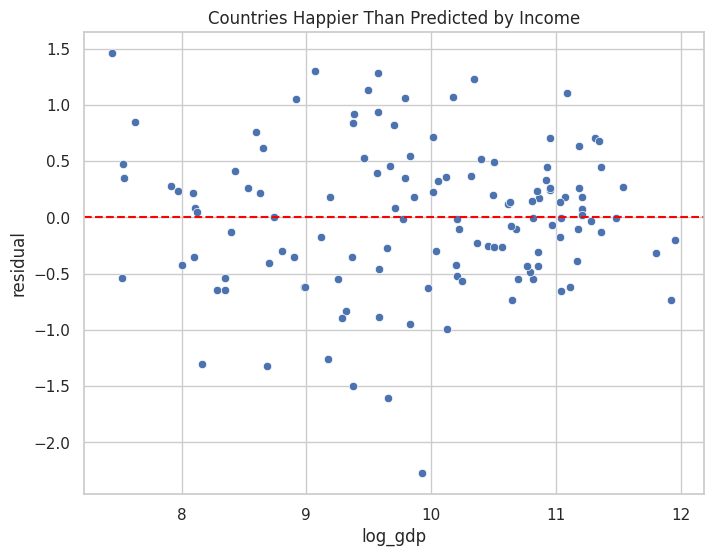

In [ ]:
# Visualize

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x="log_gdp", y="residual")
plt.axhline(0, color="red", linestyle="--")
plt.title("Countries Happier Than Predicted by Income")
plt.show()


To better understand which countries outperform or underperform relative to income, I examined the residuals from the regression model. Countries above the zero line are happier than predicted by their GDP level, while those below are less happy than expected.

In [ ]:
# Overperformers (Happier Than Income Predicts)

merged_df.sort_values("residual", ascending=False).head(10)

,Country name,Year,Happiness,GDP per capita,log_gdp,predicted,residual
82,Mozambique,2024,5.190,1705.379195,7.441543,3.728067,1.461933
88,Nicaragua,2024,6.330,8708.799831,9.072089,5.027620,1.302380
11,Belize,2024,6.711,14346.518805,9.571263,5.425463,1.285537
27,Costa Rica,2024,7.274,31106.764356,10.345181,6.042279,1.231721
34,El Salvador,2024,6.492,13264.027091,9.492811,5.362937,1.129063
38,Finland,2024,7.736,65378.384186,11.087947,6.634267,1.101733
78,Mexico,2024,6.979,26185.356471,10.172956,5.905015,1.073985
61,Kosovo,2024,6.659,17864.416015,9.790566,5.600249,1.058751
47,Honduras,2024,5.964,7486.018696,8.920792,4.907035,1.056965
45,Guatemala,2024,6.362,14368.660568,9.572805,5.426692,0.935308


## Overperformers (Happier Than Income Predicts)

These countries are significantly happier than their GDP level alone would predict.

Very important insight:

* Many are Latin American countries.

* Finland is also here which is ranked 1st in World Happiness Report from 2017 until 2024.

In [ ]:
# Underperformers (Less Happy Than Income Predicts)

merged_df.sort_values("residual").head(10)

,Country name,Year,Happiness,GDP per capita,log_gdp,predicted,residual
15,Botswana,2024,3.438,20538.132018,9.930039,5.711409,-2.273409
111,Sri Lanka,2024,3.891,15632.592485,9.657113,5.493886,-1.602886
36,Eswatini,2024,3.774,11799.202879,9.375787,5.269668,-1.495668
129,Zimbabwe,2024,3.396,5928.080625,8.687456,4.721065,-1.325065
106,Sierra Leone,2024,2.998,3522.305880,8.166871,4.306157,-1.308157
9,Bangladesh,2024,3.851,9646.769844,9.174378,5.109144,-1.258144
7,Azerbaijan,2024,4.875,25088.999376,10.130185,5.870926,-0.995926
121,Ukraine,2024,4.680,18550.462891,9.828250,5.630283,-0.950283
58,Jordan,2024,4.310,10821.490977,9.289289,5.200729,-0.890729
119,Tunisia,2024,4.552,14521.008094,9.583352,5.435098,-0.883098


## Underperformers (Less Happy Than Income Predicts)

These countries are less happy than income would suggest.

Important observation:

Some of these countries:

* Have political instability
* Conflict
* Economic crisis
* Institutional challenges


# Author

Basak Kaya

MEng Student, Mechanical & Industrial Engineering

University of Toronto